In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Defining Charting Functions

In [4]:
def draw_candle_chart(sample_df, lines, region=None):
    #create figure
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figwidth(10)

    #define width of candlestick elements
    width = .4
    width2 = .05

    #define up and down prices
    up = sample_df[sample_df.Close>=sample_df.Open]
    down = sample_df[sample_df.Close<sample_df.Open]

    #define colors to use
    col1 = 'green'
    col2 = 'red'

    #plot up prices
    plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
    plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
    plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

    #plot down prices
    plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
    plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
    plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

    #rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    for x in lines:
        plt.hlines(x, xmin = sample_df.index[0], xmax = sample_df.index[-1])
        if region is not None:
            plt.fill_between(sample_df.index, x-x*region, x+x*region, alpha = 0.4)

    #display candlestick chart
    plt.show()

In [5]:
def draw_line_chart(sample_df, lines, region=None, mavg=None):
    #create figure
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figwidth(10)
    
    if mavg is not None:
        mavg_df = sample_df[["Open","High","Low","Close"]].rolling(window = mavg).mean()
        plt.plot(mavg_df.index, mavg_df.Close)
    else:
        plt.plot(sample_df.index, sample_df.Close)
        
    #rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    for x in lines:
        plt.hlines(x, xmin = sample_df.index[0], xmax = sample_df.index[-1])
        if region is not None:
            plt.fill_between(sample_df.index, x-x*region, x+x*region, alpha = 0.4)

    #display candlestick chart
    plt.show()

# Loading Data

In [19]:
data = pd.read_csv("BTCUSDT-1m-2022-08.csv",
                  usecols = [0,1,2,3,4],
                  names = ["Date", "Open", "High", "Low", "Close"])

data["Date"] = pd.to_datetime(data["Date"], unit="ms")

print(data)

                     Date      Open      High       Low     Close
0     2022-08-01 00:00:00  23296.36  23296.78  23262.27  23280.77
1     2022-08-01 00:01:00  23280.77  23317.68  23263.01  23313.09
2     2022-08-01 00:02:00  23316.78  23317.72  23271.23  23287.89
3     2022-08-01 00:03:00  23287.89  23291.08  23263.02  23278.59
4     2022-08-01 00:04:00  23275.48  23297.48  23266.27  23277.42
...                   ...       ...       ...       ...       ...
44635 2022-08-31 23:55:00  20039.99  20049.77  20035.03  20047.55
44636 2022-08-31 23:56:00  20047.55  20052.07  20039.49  20043.22
44637 2022-08-31 23:57:00  20043.22  20056.67  20041.86  20046.30
44638 2022-08-31 23:58:00  20046.30  20052.58  20040.00  20051.51
44639 2022-08-31 23:59:00  20051.51  20057.78  20042.42  20050.02

[44640 rows x 5 columns]


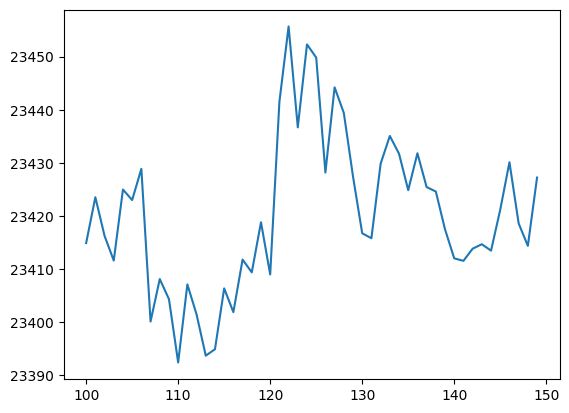

In [20]:
slice_ = slice(100,150)

sample_df = data.iloc[slice_]
sample = data.iloc[slice_][["Close"]].to_numpy().flatten()
sample_original = sample.copy()

plt.plot(sample_df.index, sample_df.Close)

# Grab Turning Points

In [33]:
from scipy.signal import argrelextrema


maxima = argrelextrema(sample, np.greater)
minima = argrelextrema(sample, np.less)

extrema = np.concatenate((maxima,minima), axis=1)[0]
extrema_prices = np.concatenate((sample[maxima], sample[minima]))

26

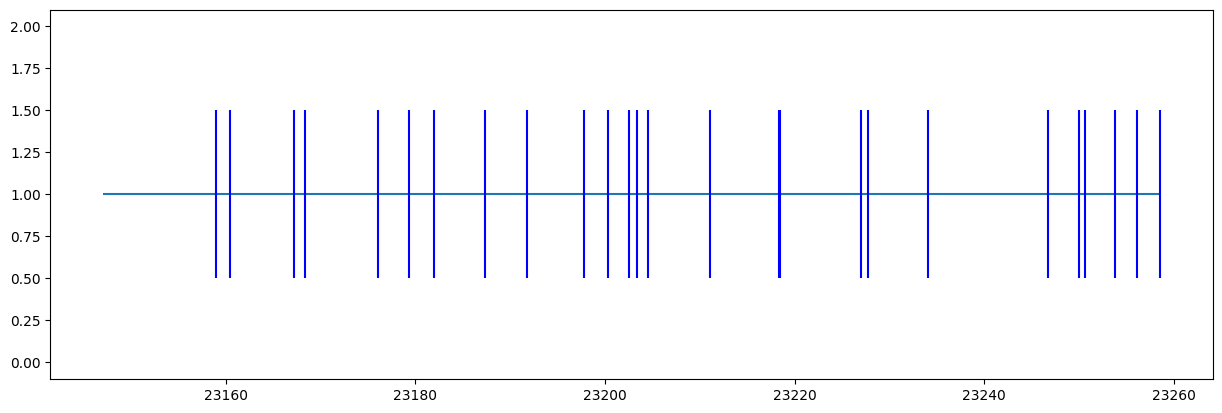

In [34]:
f = plt.figure()
f.set_figwidth(15)
plt.hlines(1,sample_original.min(),sample_original.max())  # Draw a horizontal line
plt.eventplot(extrema_prices, orientation='horizontal', colors='b')
plt.show()

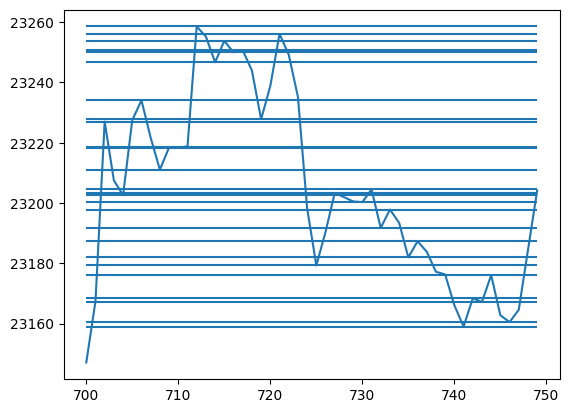

In [37]:
plt.plot(sample_df.index, sample_df.Close)
for x in extrema_prices:
    plt.hlines(x, xmin = sample_df.index[0], xmax = sample_df.index[-1])

# Estimate PDF

23227.02


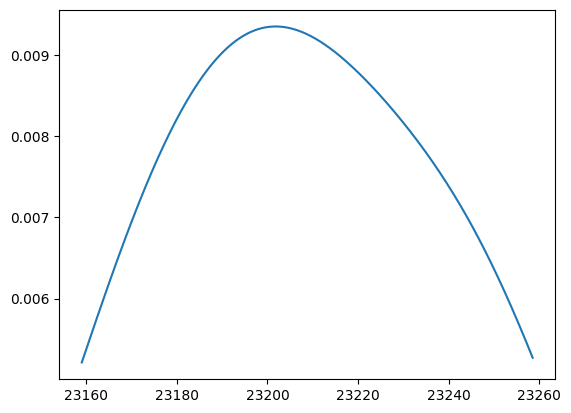

In [46]:
from sklearn.neighbors import KernelDensity

initial_price = extrema_prices[0]
print(initial_price)

## price / 5000 is nice (for btc), relatively sparse

kde = KernelDensity(kernel='gaussian', bandwidth=initial_price/1000).fit(extrema_prices.reshape(-1,1))

a, b = min(extrema_prices), max(extrema_prices)
price_range = np.linspace(a, b, 1000).reshape(-1,1)
pdf = np.exp(kde.score_samples(price_range))
plt.plot(price_range, pdf)

# Plot Results

In [47]:
from scipy.signal import find_peaks

peaks = find_peaks(pdf)[0]

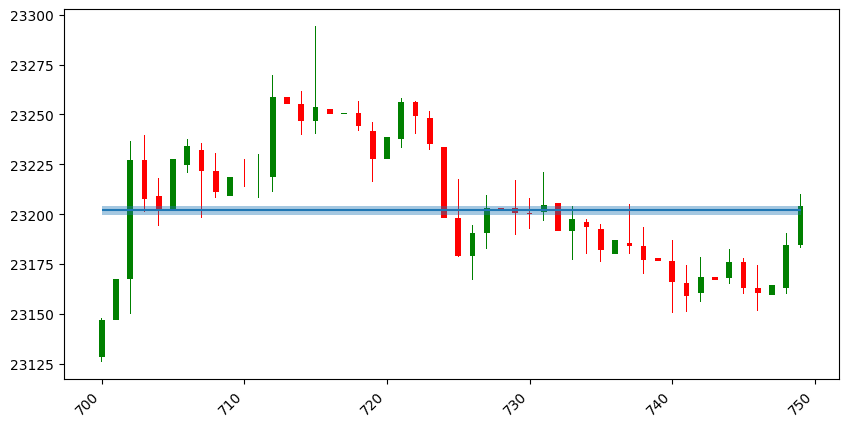

In [48]:
draw_candle_chart(sample_df, price_range[peaks], region = 0.0001)

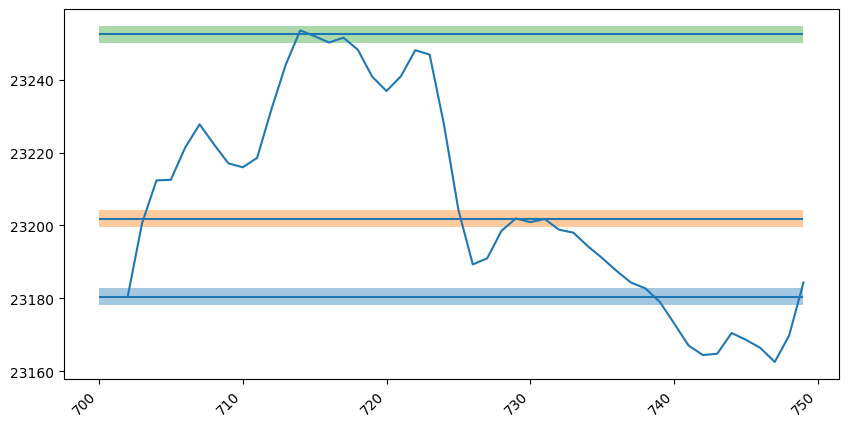

In [29]:
draw_line_chart(sample_df, price_range[peaks], region = 0.0001, mavg = 3)

# Automated bandwidth selection

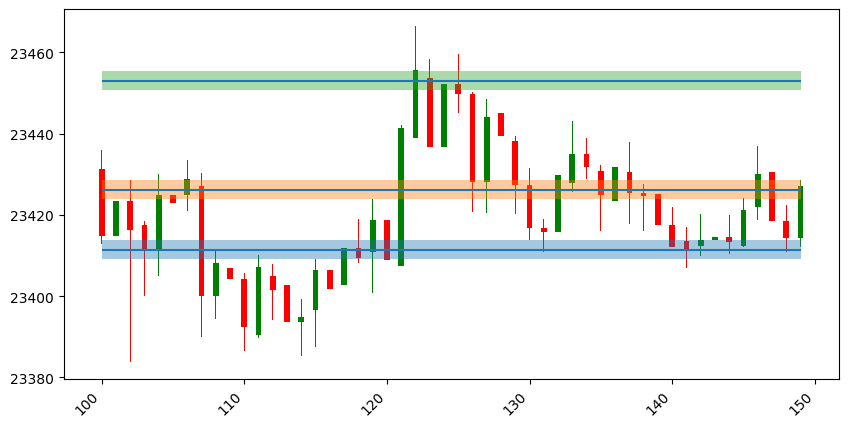

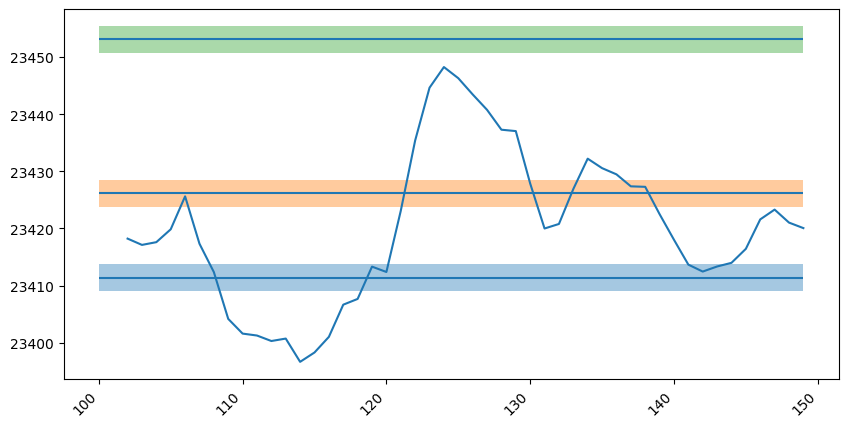

In [50]:
from scipy.signal import argrelextrema,find_peaks
from sklearn.neighbors import KernelDensity

## Input parameters
slice_ = slice(100,150)
peaks_range = [2,4]
num_peaks = -999
interval = extrema_prices[0]/10000


sample_df = data.iloc[slice_]
sample = data.iloc[slice_][["Close"]].to_numpy().flatten()
sample_original = sample.copy()

maxima = argrelextrema(sample, np.greater)
minima = argrelextrema(sample, np.less)

extrema = np.concatenate((maxima,minima), axis=1)[0]
extrema_prices = np.concatenate((sample[maxima], sample[minima]))


bandwidth = interval

while num_peaks < peaks_range[0] or num_peaks > peaks_range[1]:
    
    initial_price = extrema_prices[0]

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(extrema_prices.reshape(-1,1))

    a, b = min(extrema_prices), max(extrema_prices)
    price_range = np.linspace(a, b, 1000).reshape(-1,1)
    pdf = np.exp(kde.score_samples(price_range))
    peaks = find_peaks(pdf)[0]
    
    num_peaks = len(peaks)
    bandwidth += interval
    
    if bandwidth > 100*interval:
        print("Failed to converge, stopping...")
        break

draw_candle_chart(sample_df, price_range[peaks], region = 0.0001)
draw_line_chart(sample_df, price_range[peaks], region = 0.0001, mavg = 3)